In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable
from torchvision import transforms
from pathlib import Path
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import os
from torchsummary import summary # 输出模型信息，计算模型整体参数量
from torchviz import make_dot, make_dot_from_trace # 可视化模型前馈的计算图
from visdom import Visdom # 可视化学习曲线
import time
torch.manual_seed(1)

# Hyperparameters

In [2]:
#! Hyper Parameters
num_epochs = 3
batch_size = 32
learning_rate = 0.1

# Pre-processing

In [3]:
class SHM_Dataset(Dataset):
    """ Prepare dataset for pytorch
        Ref: https://pytorch.org/tutorials/beginner/basics/data_tutorial.html
    """

    def __init__(self, case, data_file, transform): 
        self.case = case
        self.data_file = Path(data_file)
        self.data_df = pd.read_json(self.data_file, dtype=np.array)
        # self.data = self.data_df.cat()
        self.data = self.data_df.stack()
        self.labels = pd.DataFrame([self.case,]*self.data_df.shape[0]*self.data_df.shape[1])
        self.transform = transform
    
    def __len__(self):
        return self.labels.shape[0]

    def __getitem__(self, index):
        label = int(self.labels.iloc[index])
        feature = np.array(self.data.iloc[index])

        # trans1 = transforms.ToTensor()
        # feature_tr1 = trans1(feature)
        # mean, std = feature_tr1.mean(), feature_tr1.std()
        mean, std = feature.mean(), feature.std()

        trans2 = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean, std)])
        feature_tr2 = trans2(feature)
        # print(f"feature: {feature.shape}, label: {label.shape}")
        return feature_tr2, label


# shmDS = SHM_Dataset(1, "~/Codes/homework/data/SHM/shm01s.json")
# print("There is", len(shmDS), "samples in the given dataset")

The target span needs to be 0 to N-1 [Ref: IndexError: Target is out of bounds](https://pytorch.org/docs/master/generated/torch.nn.CrossEntropyLoss.html)

In [4]:
trans = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
# trans = transforms.ToTensor()

shmDS_1 = SHM_Dataset(0, "~/Codes/homework/data/SHM/shm01s.json", trans) # Case 1
shmDS_2 = SHM_Dataset(1, "~/Codes/homework/data/SHM/shm02s.json", trans)
shmDS_3 = SHM_Dataset(2, "~/Codes/homework/data/SHM/shm03s.json", trans)
shmDS_4 = SHM_Dataset(3, "~/Codes/homework/data/SHM/shm04s.json", trans)
shmDS_5 = SHM_Dataset(4, "~/Codes/homework/data/SHM/shm05s.json", trans)
shmDS_6 = SHM_Dataset(5, "~/Codes/homework/data/SHM/shm06s.json", trans)
shmDS_7 = SHM_Dataset(6, "~/Codes/homework/data/SHM/shm07s.json", trans)
shmDS_8 = SHM_Dataset(7, "~/Codes/homework/data/SHM/shm08s.json", trans)
shmDS_9 = SHM_Dataset(8, "~/Codes/homework/data/SHM/shm09s.json", trans)
shmDS = shmDS_1 + shmDS_2 + shmDS_3 + shmDS_4 + shmDS_5 + shmDS_6 + shmDS_7 + shmDS_8 + shmDS_9

In [5]:
print("There is", len(shmDS), "samples in the given dataset")

There is 24672 samples in the given dataset


Let's have a look on a single sample:

Feature batch shape: torch.Size([32, 1, 16, 16])
Labels batch shape: torch.Size([32])


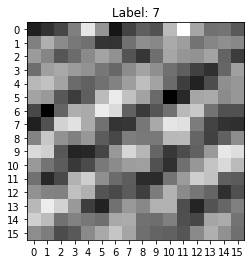

In [6]:
train_loader = DataLoader(shmDS, batch_size=batch_size, shuffle=True) # split samples into mini-batches and reshuffle the data to reduce overfitting
test_loader = DataLoader(shmDS, batch_size=batch_size, shuffle=False)

train_features, train_labels = next(iter(train_loader))
test_features, test_labels = next(iter(test_loader))
# train_features = train_features.unsqueeze(dim=1)
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")

img = train_features[0].squeeze()
label = train_labels[0]
fig, axis = plt.subplots()
axis.imshow(img, cmap="gray")

axis.set(title=f"Label: {label}", xticks=range(16), yticks=range(16))
plt.show()
# print(f"Input features: {img.shape}\n\t{img}")
# print(f"Label: {label.shape}\n\t{label}")

# Build the neural network

## CNN Model

In [7]:
# Four-layer convolution
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        ## by HB
        # self.conv1 = nn.Sequential(
        #     nn.Conv2d(1, 4, kernel_size=4, padding=1),
        #     nn.BatchNorm2d(4),
        #     nn.ReLU(),
        #     nn.MaxPool2d(2))
        # self.conv2 = nn.Sequential(
        #     nn.Conv2d(4, 8, kernel_size=4, padding=1),
        #     nn.BatchNorm2d(8),
        #     nn.ReLU(),
        #     nn.MaxPool2d(2))
        # self.fc = nn.Linear(3*3*8, 9)
        
        ## by Chen
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 4, kernel_size=3, padding=1),
            nn.BatchNorm2d(4),
            nn.ReLU(),
            nn.MaxPool2d(2))
        self.conv2 = nn.Sequential(
            nn.Conv2d(4, 8, kernel_size=3, padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.MaxPool2d(2))
        self.conv3 = nn.Sequential(
            nn.Conv2d(8, 16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2))
        self.conv4 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2))
        self.fc = nn.Linear(32 * 1 * 1, 9)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        # print(x.shape)
        x = x.view(x.size(0), -1) 
        # print(x.shape)
        x = self.fc(x)
        return x

cnn = CNN()

## Loss and Optimizer

In [8]:
loss_func = nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(cnn.parameters(), lr=learning_rate)
optimizer = torch.optim.SGD(cnn.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.1)

# Train the model

In [9]:
# for epoch in range(num_epochs):
#     for i, (train_features, train_labels) in enumerate(train_loader):
#         train_features = Variable(train_features)
#         train_features = train_features.float()
#         train_labels = Variable(train_labels)

#         # Forward + Backward + Optimize
#         optimizer.zero_grad()
#         outputs = cnn(train_features)
#         loss = loss_func(outputs, train_labels)
#         loss.backward()
#         optimizer.step()

#         if (i + 1) % 100 == 0:
#             print('Epoch [%d/%d], Iter [%d/%d], Loss: %.4f'
#                   % (epoch + 1, num_epochs, i + 1, len(shmDS) // batch_size, loss.item()))
#     scheduler.step()

In [14]:
#! Train the model: Visualization of Loss
viz = Visdom()
#viz.images(train_features[:10],nrow=100)  # visdom可视化部分数据
time.sleep(0.5) # 为防止可视化视窗重叠现象，停顿0.5秒
test_data = Variable(train_features, volatile=True).float()
line = viz.line(np.arange(10)) # 创建线图可视化窗口
start_time = time.time() # 起始时间设置
time_p, tr_acc, ts_acc, loss_p = [], [], [], [] # 可视化所需数据点
text = viz.text("<h1>Convolution Nueral Network</h1>") # 创建可视化数据视窗
for epoch in range(num_epochs):
    # 由于分批次学习，输出loss为一批平均，需要累积or平均每个batch的loss
    sum_loss, sum_acc, sum_step = 0., 0., 0.
    
    for test_features, test_labels in test_loader:
        test_features = Variable(test_features)
        test_features = test_features.float()
        test_labels = Variable(test_labels)

    for i, (train_features, train_labels) in enumerate(train_loader, 1):
        train_features = Variable(train_features)
        train_features = train_features.float()
        train_labels = Variable(train_labels)
        
        train_out = cnn(train_features)
        loss = loss_func(train_out, train_labels) 

        sum_loss += loss.item()*len(train_labels)
        _, pred_tr = torch.max(train_out.data, 1)
        sum_acc += sum(pred_tr==train_labels).item()
        sum_step += train_labels.size(0)

        optimizer.zero_grad()  # 学习反馈
        loss.backward()
        optimizer.step()

        if i % 20 == 0: # 每20个batch可视化一下数据
            test_out = cnn(test_features)
            _, pred_ts = torch.max(test_out.data, 1)

            rightnum = pred_ts.eq(test_labels.view_as(pred_ts)).sum().item()
            acc =  rightnum/float(test_labels.size(0))
            print("epoch: [{}/{}] | Loss: {:.4f} | TR_acc: {:.4f} | TS_acc: {:.4f} | Time: {:.1f}".format(epoch+1, epoch,
                                    sum_loss/(sum_step), sum_acc/(sum_step), acc, time.time()-start_time))
            # 可视化部分
            time_p.append(time.time()-start_time)
            tr_acc.append(sum_acc/sum_step)
            ts_acc.append(acc)
            loss_p.append(sum_loss/sum_step)
            viz.line(X=np.column_stack((np.array(time_p), np.array(time_p), np.array(time_p))),
                     Y=np.column_stack((np.array(loss_p), np.array(tr_acc), np.array(ts_acc))),
                     win=line,
                     opts=dict(legend=["Loss", "TRAIN_acc", "TEST_acc"],
                     ytickmin=0, ytickmax=2, ytickstep=0.5,
                     ))
            # visdom text 支持html语句
            viz.text("<p style='color:red'>epoch:{}</p><br><p style='color:blue'>Loss:{:.4f}</p><br>"
                     "<p style='color:BlueViolet'>TRAIN_acc:{:.4f}</p><br><p style='color:orange'>TEST_acc:{:.4f}</p><br>"
                     "<p style='color:green'>Time:{:.2f}</p>".format(epoch, sum_loss/sum_step, sum_acc/sum_step, acc,
                                time.time()-start_time),
                     win=text)
            sum_loss, sum_acc, sum_step = 0., 0., 0.
    scheduler.step()

Setting up a new session...
/var/folders/4z/qqkm946s6p55jwd60wd7w2n40000gn/T/ipykernel_54076/2646359967.py:5: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  test_data = Variable(train_features, volatile=True).float()


epoch: [1/0] | Loss: 0.6562 | TR_acc: 0.7812 | TS_acc: 0.7188 | Time: 7.5
epoch: [1/0] | Loss: 0.5649 | TR_acc: 0.8219 | TS_acc: 0.7188 | Time: 7.8
epoch: [1/0] | Loss: 0.6395 | TR_acc: 0.7891 | TS_acc: 0.7188 | Time: 8.1
epoch: [1/0] | Loss: 0.6255 | TR_acc: 0.7969 | TS_acc: 0.7188 | Time: 8.5
epoch: [1/0] | Loss: 0.6590 | TR_acc: 0.7719 | TS_acc: 0.7188 | Time: 8.8
epoch: [1/0] | Loss: 0.5700 | TR_acc: 0.8078 | TS_acc: 0.7188 | Time: 9.2
epoch: [1/0] | Loss: 0.5826 | TR_acc: 0.8141 | TS_acc: 0.7188 | Time: 9.5
epoch: [1/0] | Loss: 0.5729 | TR_acc: 0.8219 | TS_acc: 0.7188 | Time: 9.9
epoch: [1/0] | Loss: 0.5737 | TR_acc: 0.8078 | TS_acc: 0.7188 | Time: 10.2
epoch: [1/0] | Loss: 0.5505 | TR_acc: 0.8125 | TS_acc: 0.7188 | Time: 10.8
epoch: [1/0] | Loss: 0.5850 | TR_acc: 0.8031 | TS_acc: 0.7188 | Time: 11.2
epoch: [1/0] | Loss: 0.6137 | TR_acc: 0.7984 | TS_acc: 0.7188 | Time: 11.5
epoch: [1/0] | Loss: 0.6513 | TR_acc: 0.7875 | TS_acc: 0.7188 | Time: 11.9
epoch: [1/0] | Loss: 0.6548 | TR_

# Test the model

In [11]:
cnn.eval()  # Change to test form, application scenarios such as: dropout
correct = 0
total = 0
for test_features, test_labels in test_loader:
    test_features = Variable(test_features)
    test_features = test_features.float()
    test_labels = Variable(test_labels)

    outputs = cnn(test_features)
    _, predicted = torch.max(outputs.data, 1)
    total += test_labels.size(0)
    correct += (predicted == test_labels.data).sum()
    
print(' Test Accuracy: %d %%' % (100 * correct / total))

# Save the Trained Model
# torch.save(cnn.state_dict(), 'cnn.pkl')

 Test Accuracy: 78 %


# Debugging ...

In [12]:
print("The last batch size should be", len(shmDS)%batch_size)
print("outputs has a shape of:", outputs.shape)
print("\tthe 1st item is:", outputs[1].shape, outputs[1])

print("predicted has a shape of:", predicted.shape)
print("\tthe 1st item is:", predicted[1].shape, predicted[1])

print("test_labels has a shape of:", test_labels.shape)
print("\tthe 1st item is:", test_labels[1].shape, test_labels[1])

The last batch size should be 0
outputs has a shape of: torch.Size([32, 9])
	the 1st item is: torch.Size([9]) tensor([-0.2443,  4.7957, -0.6776, -3.9314, -2.2064,  2.4560,  0.6055, -0.2776,
        -1.8728], grad_fn=<SelectBackward0>)
predicted has a shape of: torch.Size([32])
	the 1st item is: torch.Size([]) tensor(1)
test_labels has a shape of: torch.Size([32])
	the 1st item is: torch.Size([]) tensor(8)
